# Классификация клиентов банка

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import time

from sklearn import metrics, ensemble
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
import optuna
from ml.preprocessing import MulticollinearityCleaner, LowInformationCleaner, Encoder, clean_outliers

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import ml.plots as mlplots
from ml.learn import get_pr_curve

import warnings
pio.renderers.default = "png"
warnings.filterwarnings('ignore')

Данные о клиентах банка:

- age - возраст;
- job - сфера занятости;
- marital - семейное положение;
- education - уровень образования;
- default - имеется ли просроченный кредит;
- housing - имеется ли кредит на жильё;
- loan - имеется ли кредит на личные нужды;
- balance - баланс.

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact - тип контакта с клиентом;
- month - месяц, в котором был последний контакт;
- day - день, в который был последний контакт;
- duration - продолжительность контакта в секундах.

Прочие признаки:

- campaign - количество контактов с этим клиентом в течение текущей кампании;
- pdays - количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании;
- previous - количество контактов до текущей кампании;
- poutcome - результат прошлой маркетинговой кампании.

Целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке.

## Загрузка данных

In [2]:
df = pd.read_csv('./data/bank_fin.csv', sep=';')
display(df)
df.info()

age          job  marital  education default       balance housing  \
0       59       admin.  married  secondary      no   2 343,00 $      yes   
1       56       admin.  married  secondary      no      45,00 $       no   
2       41   technician  married  secondary      no   1 270,00 $      yes   
3       55     services  married  secondary      no   2 476,00 $      yes   
4       54       admin.  married   tertiary      no     184,00 $       no   
...    ...          ...      ...        ...     ...           ...     ...   
11157   33  blue-collar   single    primary      no       1,00 $      yes   
11158   39     services  married  secondary      no     733,00 $       no   
11159   32   technician   single  secondary      no      29,00 $       no   
11160   43   technician  married  secondary      no         0  $       no   
11161   34   technician  married  secondary      no         0  $       no   

      loan   contact  day month  duration  campaign  pdays  previous poutcome  \
0       no   unknown    5   may      1042         1     -1         0  unknown   
1       no   unknown    5   may      1467         1     -1         0  unknown   
2       no   unknown    5   may      1389         1     -1         0  unknown   
3       no   unknown    5   may       579         1     -1         0  unknown   
4       no   unknown    5   may       673         2     -1         0  unknown   
...    ...       ...  ...   ...       ...       ...    ...       ...      ...   
11157   no  cellular   20   apr       257         1     -1         0  unknown   
11158   no   unknown   16   jun        83         4     -1         0  unknown   
11159   no  cellular   19   aug       156         2     -1         0  unknown   
11160  yes  cellular    8   may         9         2    172         5  failure   
11161   no  cellular    9   jul       628         1     -1         0  unknown   

      deposit  
0         yes  
1         yes  
2         yes  
3         yes  
4         yes  
...       ...  
11157      no  
11158      no  
11159      no  
11160      no  
11161      no  

[11162 rows x 17 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


## Предобработка данных

In [3]:
df['balance'] = df['balance'].apply(lambda x: float(x.replace('$', '').replace(' ', '').replace(',', '.')) if type(x) is str else x)

### Обработка пропусков

In [4]:
df_isnull = df.isnull().sum() / df.shape[0]
df_isnull[df_isnull > 0]

balance    0.00224
dtype: float64

In [5]:
df['balance'][df['balance'].isnull()] = df['balance'].median()  # Заполнение пропусков медианой

### Удаление дубликатов

In [6]:
duplicates = df.duplicated()
duplicates = duplicates[duplicates].index
print('Количество дубликатов:', duplicates.shape[0])
df.drop(index=duplicates, inplace=True)

Количество дубликатов: 0


## Разведывательный анализ

### Визуализация

In [7]:
# Распределение признаков на числовые и категориальные
TARGET_FEATURE = 'deposit'
RANDOM_STATE = 42
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']
num_cols = ['balance', 'duration', 'campaign', 'pdays', 'previous', 'age']
cols = set(df.columns).difference([TARGET_FEATURE]).difference(cat_cols).difference(num_cols)
print(f'Нераспределённые признаки {cols}' if cols else 'Все признаки распределены')

Все признаки распределены


In [8]:
display(df.describe(include='all'))

age         job  marital  education default       balance  \
count   11162.000000       11162    11162      11162   11162  11162.000000   
unique           NaN          12        3          4       2           NaN   
top              NaN  management  married  secondary      no           NaN   
freq             NaN        2566     6351       5476   10994           NaN   
mean       41.231948         NaN      NaN        NaN     NaN   1526.936033   
std        11.913369         NaN      NaN        NaN     NaN   3224.829691   
min        18.000000         NaN      NaN        NaN     NaN  -6847.000000   
25%        32.000000         NaN      NaN        NaN     NaN    123.000000   
50%        39.000000         NaN      NaN        NaN     NaN    550.000000   
75%        49.000000         NaN      NaN        NaN     NaN   1699.000000   
max        95.000000         NaN      NaN        NaN     NaN  81204.000000   

       housing   loan   contact           day  month      duration  \
count    11162  11162     11162  11162.000000  11162  11162.000000   
unique       2      2         3           NaN     12           NaN   
top         no     no  cellular           NaN    may           NaN   
freq      5881   9702      8042           NaN   2824           NaN   
mean       NaN    NaN       NaN     15.658036    NaN    371.993818   
std        NaN    NaN       NaN      8.420740    NaN    347.128386   
min        NaN    NaN       NaN      1.000000    NaN      2.000000   
25%        NaN    NaN       NaN      8.000000    NaN    138.000000   
50%        NaN    NaN       NaN     15.000000    NaN    255.000000   
75%        NaN    NaN       NaN     22.000000    NaN    496.000000   
max        NaN    NaN       NaN     31.000000    NaN   3881.000000   

            campaign         pdays      previous poutcome deposit  
count   11162.000000  11162.000000  11162.000000    11162   11162  
unique           NaN           NaN           NaN        4       2  
top              NaN           NaN           NaN  unknown      no  
freq             NaN           NaN           NaN     8326    5873  
mean        2.508421     51.330407      0.832557      NaN     NaN  
std         2.722077    108.758282      2.292007      NaN     NaN  
min         1.000000     -1.000000      0.000000      NaN     NaN  
25%         1.000000     -1.000000      0.000000      NaN     NaN  
50%         2.000000     -1.000000      0.000000      NaN     NaN  
75%         3.000000     20.750000      1.000000      NaN     NaN  
max        63.000000    854.000000     58.000000      NaN     NaN

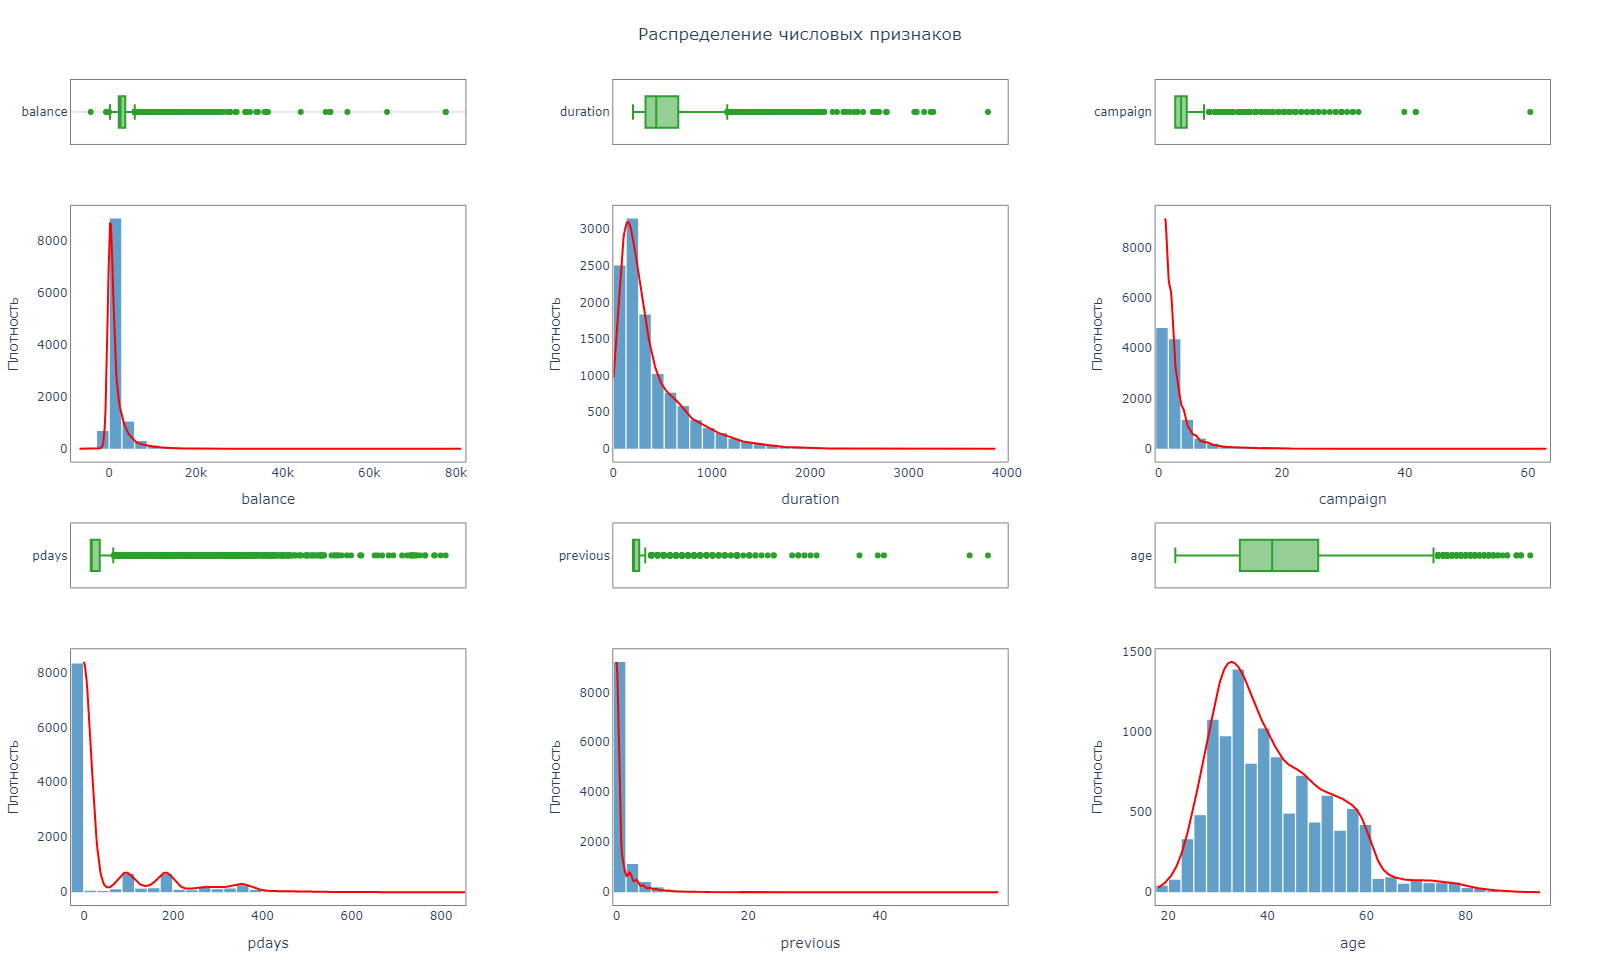

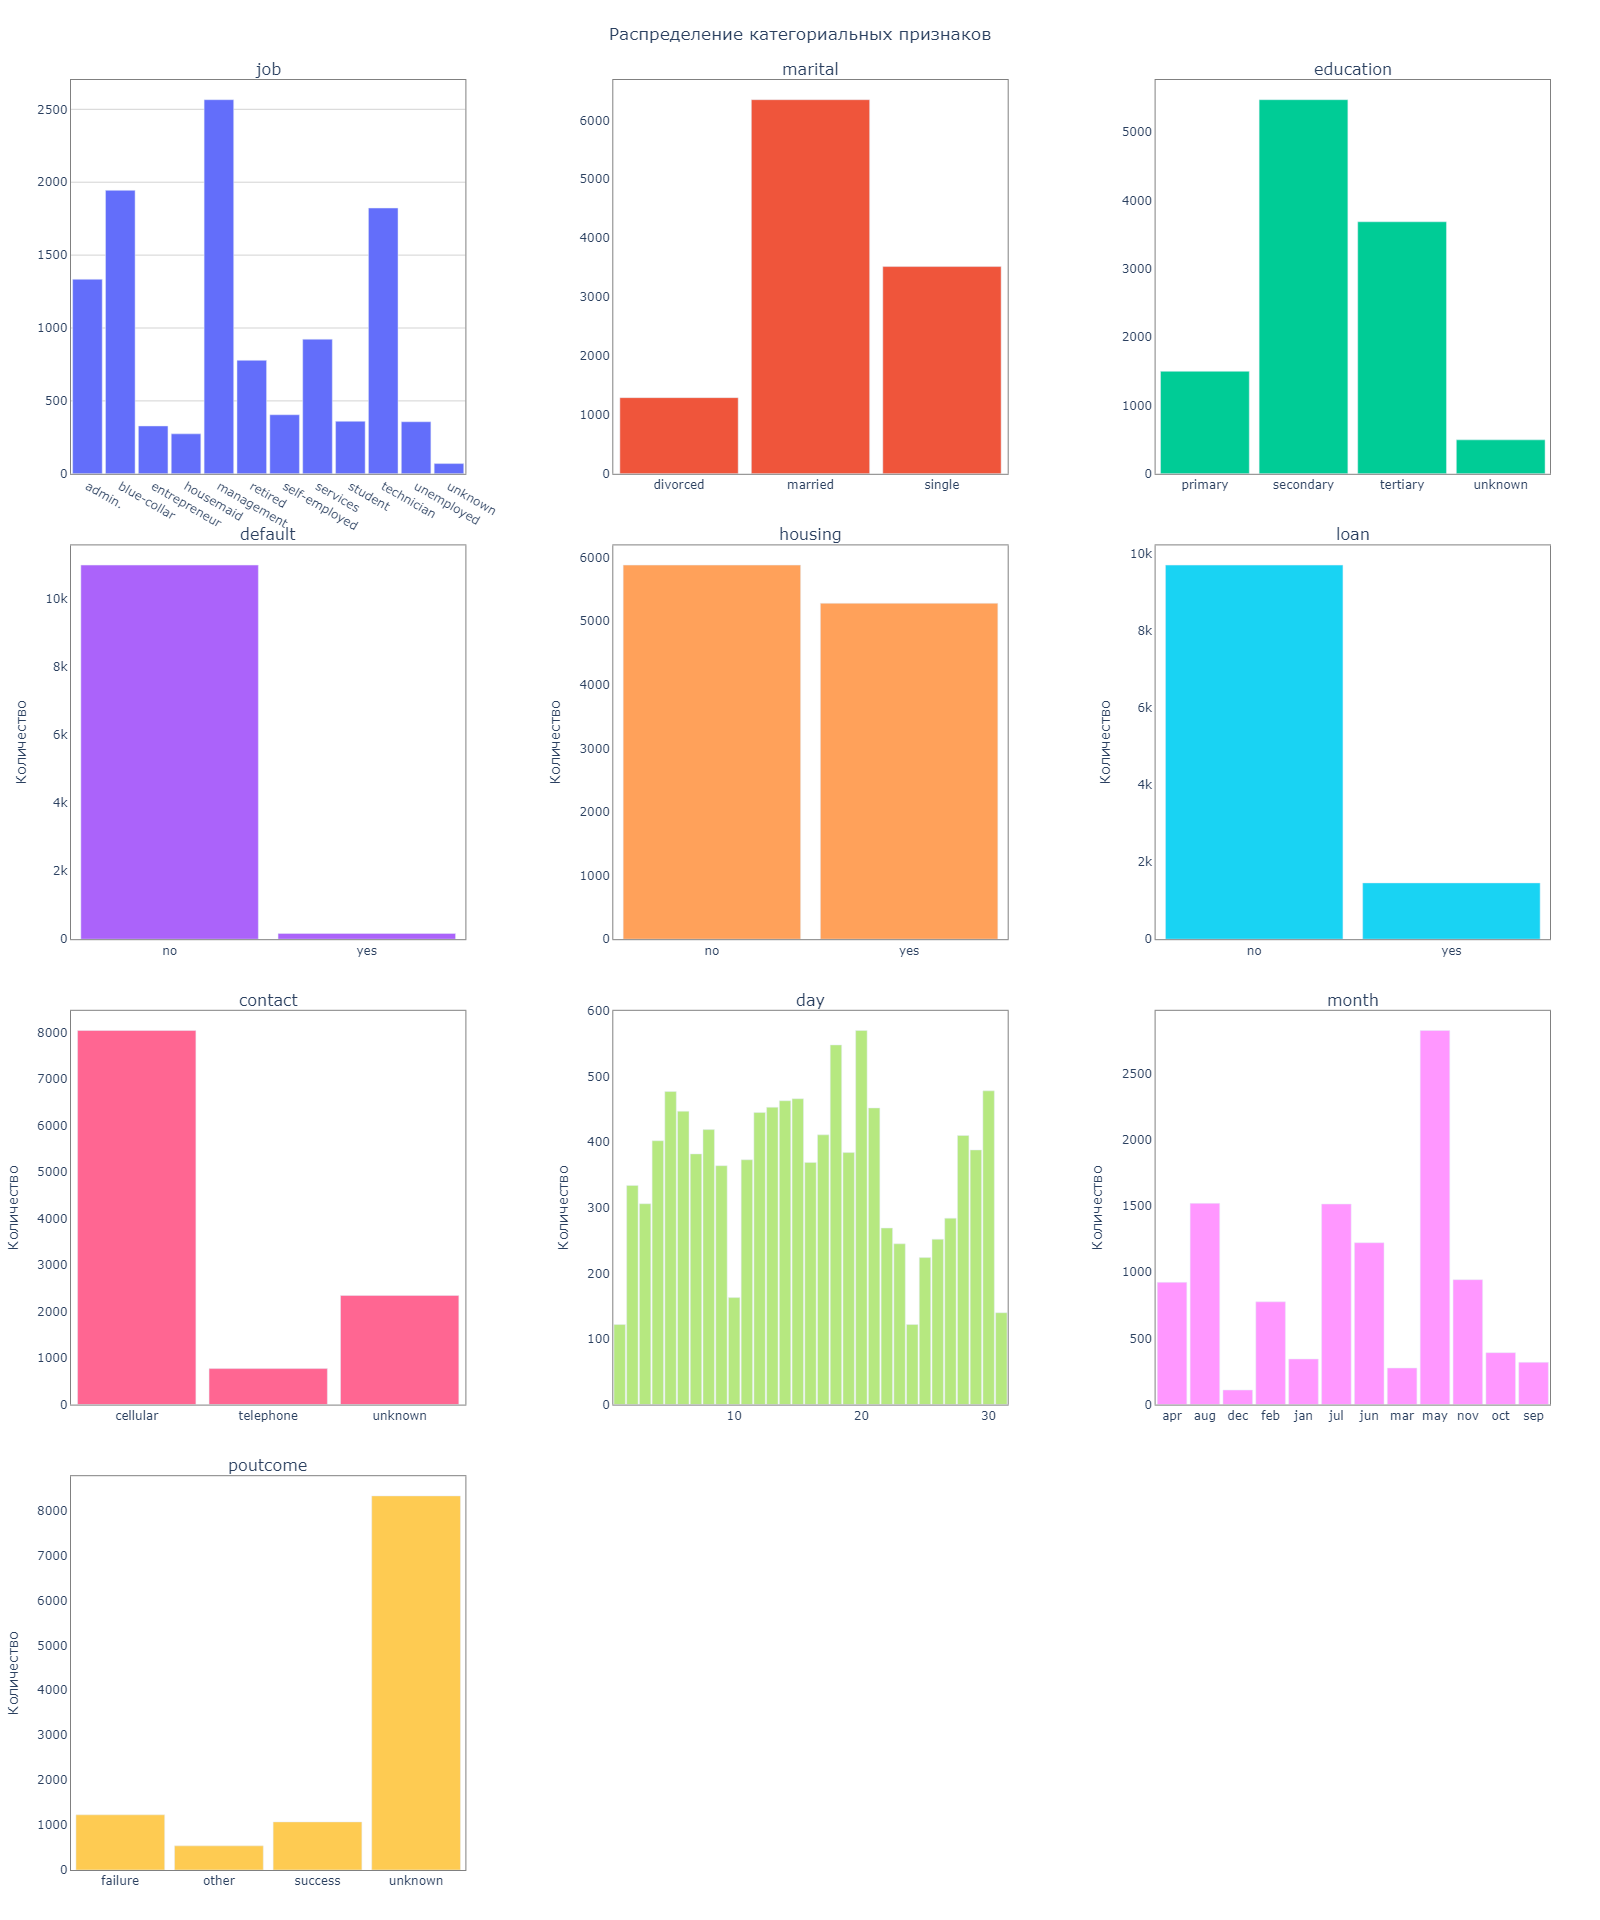

In [9]:
mlplots.distribution_vis(df, x_features=num_cols, title='Распределение числовых признаков', width=1600)
mlplots.distribution_vis(df, x_features=cat_cols, is_category=True, title='Распределение категориальных признаков', width=1600)

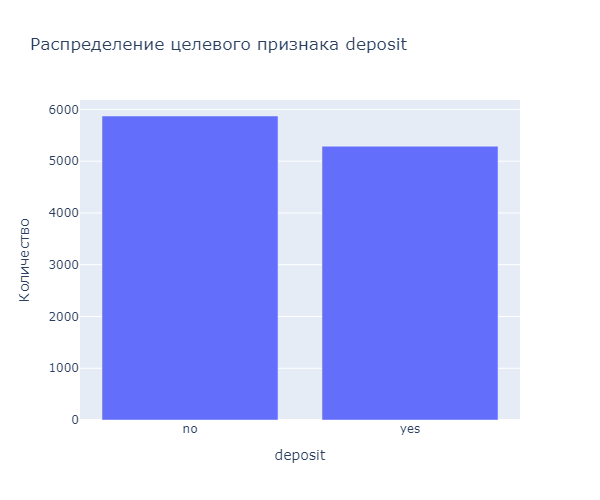

In [10]:
px.bar(df[TARGET_FEATURE].value_counts(), width=600, title=f'Распределение целевого признака {TARGET_FEATURE}', labels={
       'value': 'Количество'}).update_layout(showlegend=False)

### Проектирование признаков

In [11]:
# Создание признака возрастных групп
def get_age_group(age: int):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    elif age >= 60:
        return '60+'

df['age_group'] = df['age'].apply(get_age_group)
cat_cols.append('age_group')

Ответим на следующие вопросы бизнеса:
1. Для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач?
2. В каком месяце чаще всего отказывались от предложения открыть депозит?
3. В каких возрастных группах более склонны открывать депозит, чем отказываться от предложения? 
4. Люди с каким образованием и семейным статусом наиболее склонны открыть депозит?

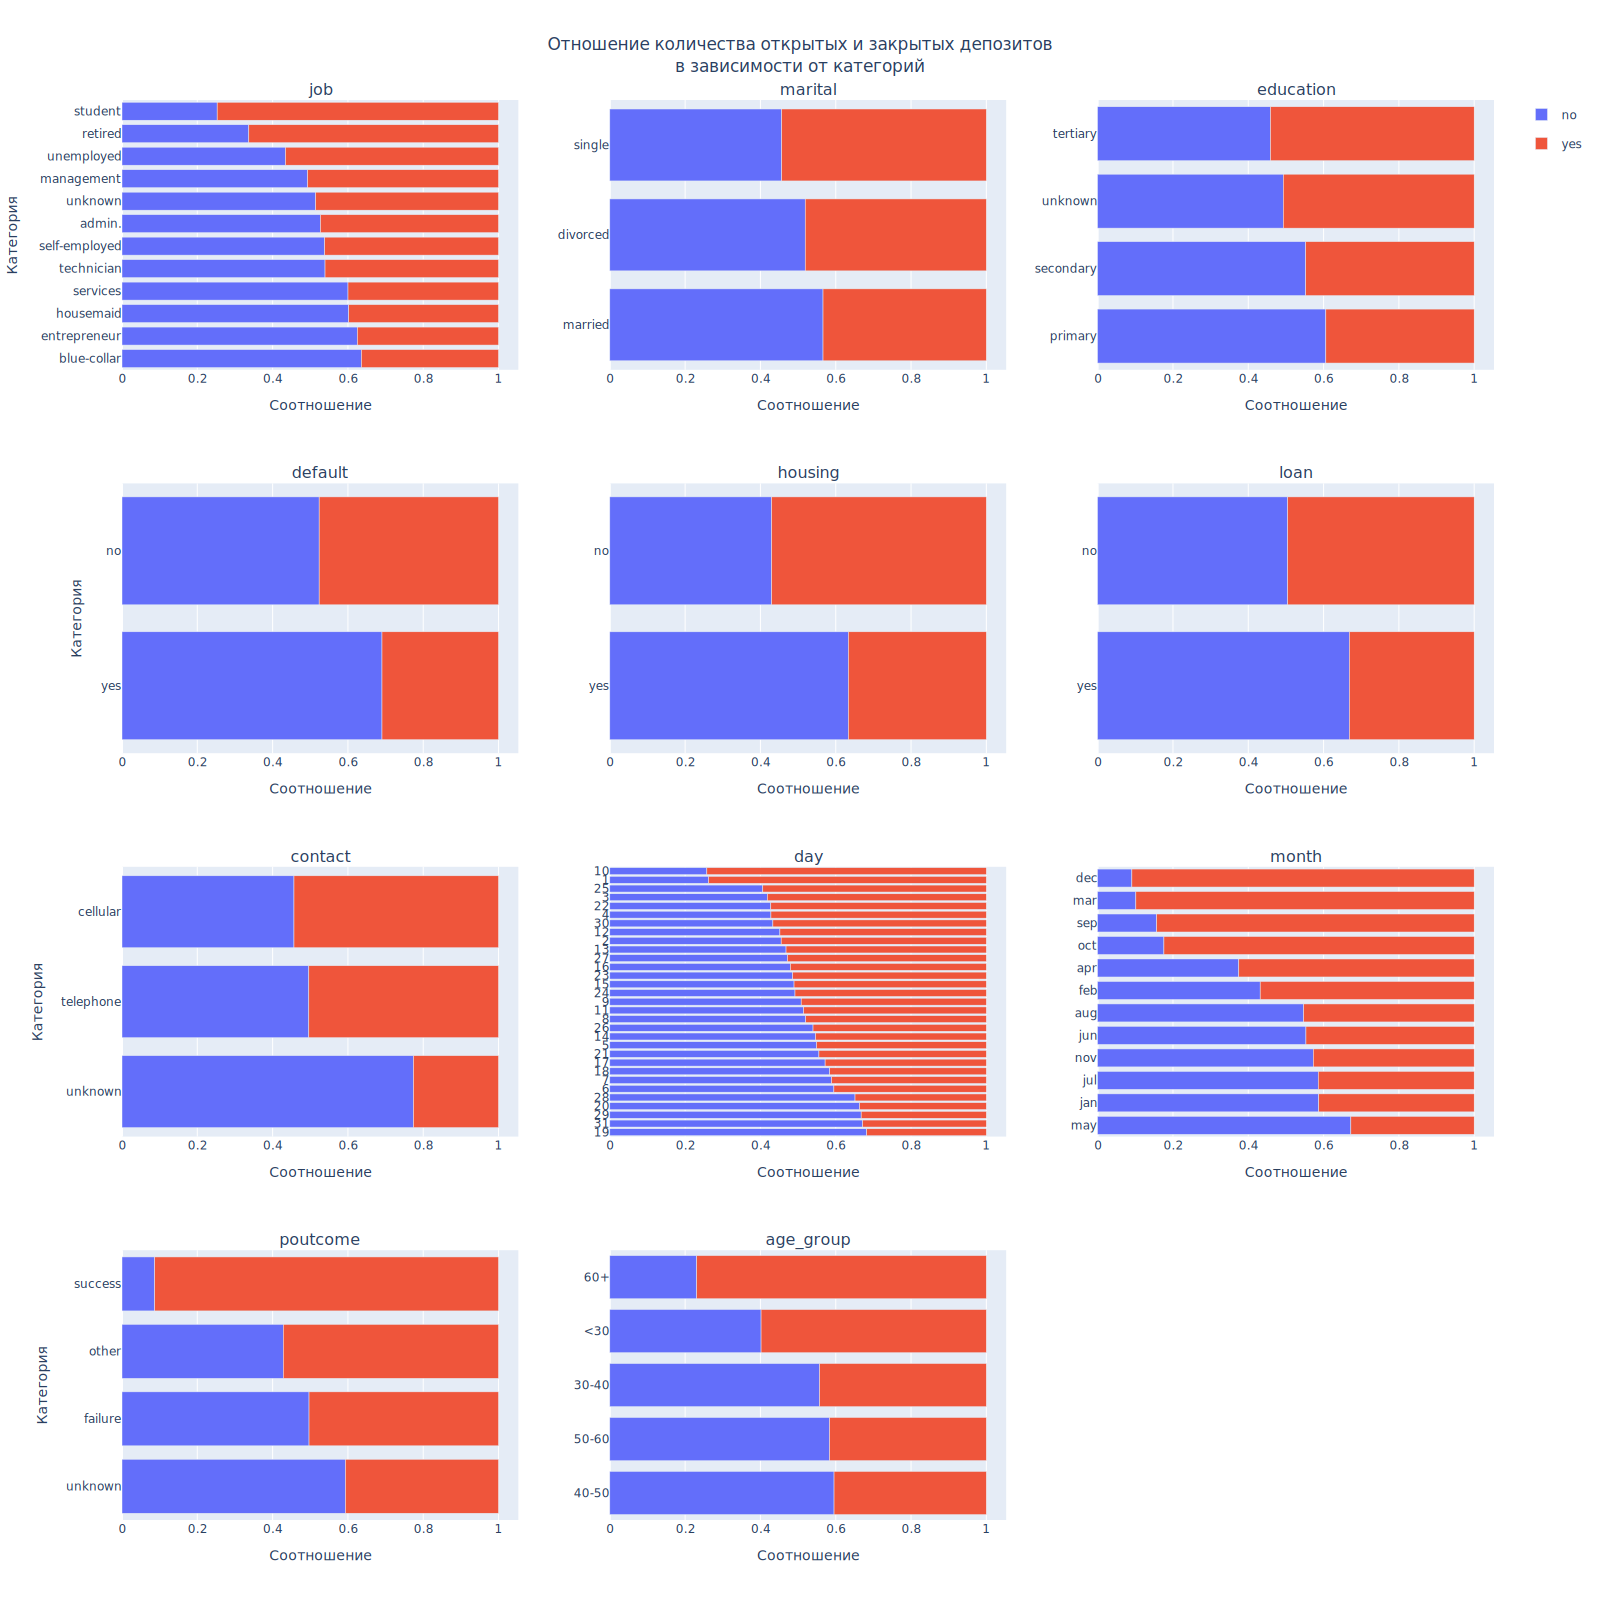

In [12]:
mlplots.dependency_vis(df[num_cols], df[TARGET_FEATURE], is_category=False, 
               title='Зависимость целевого признака от числовых факторов', aspect_ratio=0.3)
# sns.pairplot(pd.concat([df[num_cols], df[TARGET_FEATURE]], axis=1), hue=TARGET_FEATURE)
mlplots.dependency_vis(df[cat_cols], df[TARGET_FEATURE], is_category=True, 
               title='Отношение количества открытых и закрытых депозитов<br>в зависимости от категорий')

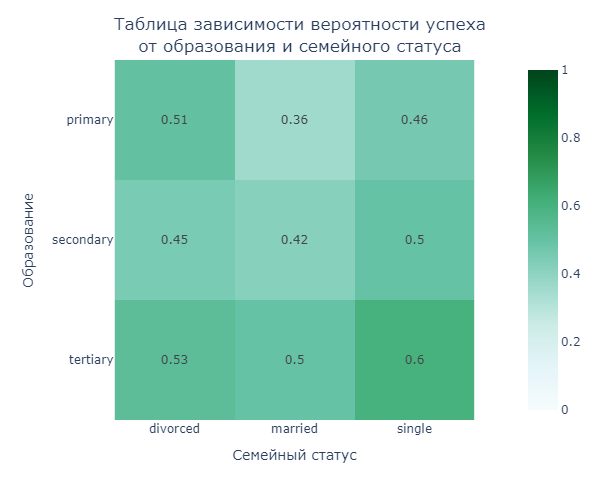

In [13]:
df_crosstab = df.copy()
df_crosstab = df_crosstab[df_crosstab['education'] != 'unknown']
df_crosstab = pd.crosstab(df_crosstab['education'], df_crosstab['marital'], df_crosstab['deposit'],
                          aggfunc=lambda x: x.value_counts(normalize=True)['yes']).round(2)
px.imshow(df_crosstab, width=600, color_continuous_scale='BuGn', text_auto=True, zmin=0, zmax=1
          ).update_layout(title_text='Таблица зависимости вероятности успеха<br>от образования и семейного статуса', title_x=0.5, xaxis_title='Семейный статус', yaxis_title='Образование')

Ответы на вопросы бизнеса:
1. Для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач?\
Успех в текущей маркетинговой кампании превалирует над количеством неудач для успешного статуса предыдущей.
2. В каком месяце чаще всего отказывались от предложения открыть депозит?\
Чаще всего клиенты отказывалиь от предложения в мае месяце.
3. В каких возрастных группах более склонны открывать депозит, чем отказываться от предложения?\
Клиенты в возрастных группах "60+" и "<30" более склонны открывать депозит чем отказываться.
4. Люди с каким образованием и семейным статусом наиболее склонны открыть депозит?\
Люди с высшим образованием и вне брака наиболее склонны открыть депозит.

## Преобразование данных

In [14]:
X, y = df.drop(columns=TARGET_FEATURE), df[TARGET_FEATURE]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_STATE)

### Кодирование

In [15]:
encoder = Encoder(cat_cols, method='ordinal')
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
for col in encoder.cols_droped:
    cat_cols.remove(col)
cat_cols += encoder.cols_added
# Кодирование целевого признака
target_encoder = ce.OrdinalEncoder(mapping=[{'col': 'deposit', 'mapping': {'no': 0, 'yes': 1}}])
y_train = target_encoder.fit_transform(y_train).iloc[:, 0]
y_test = target_encoder.fit_transform(y_test).iloc[:, 0]

### Удаление выбросов

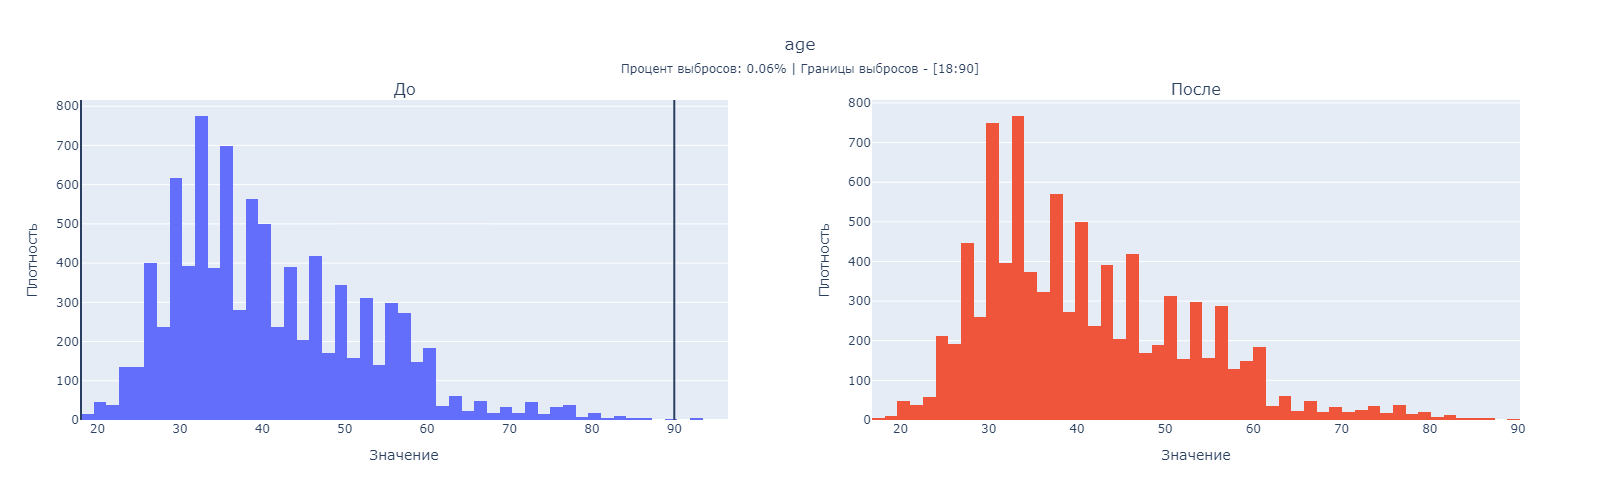

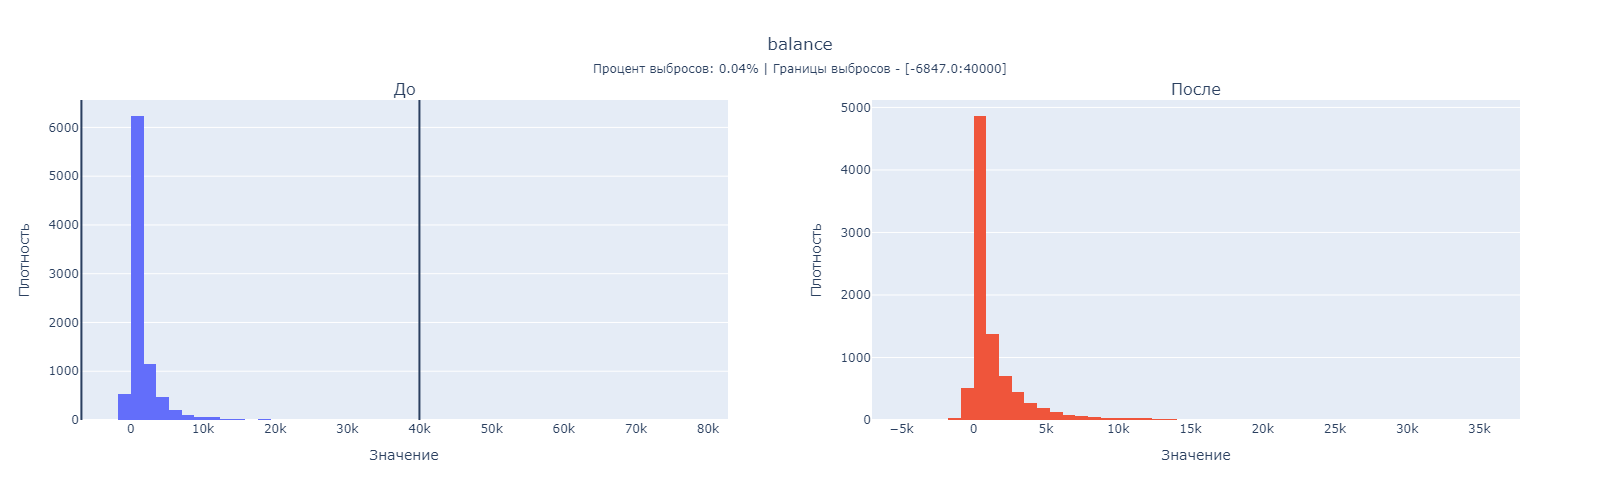

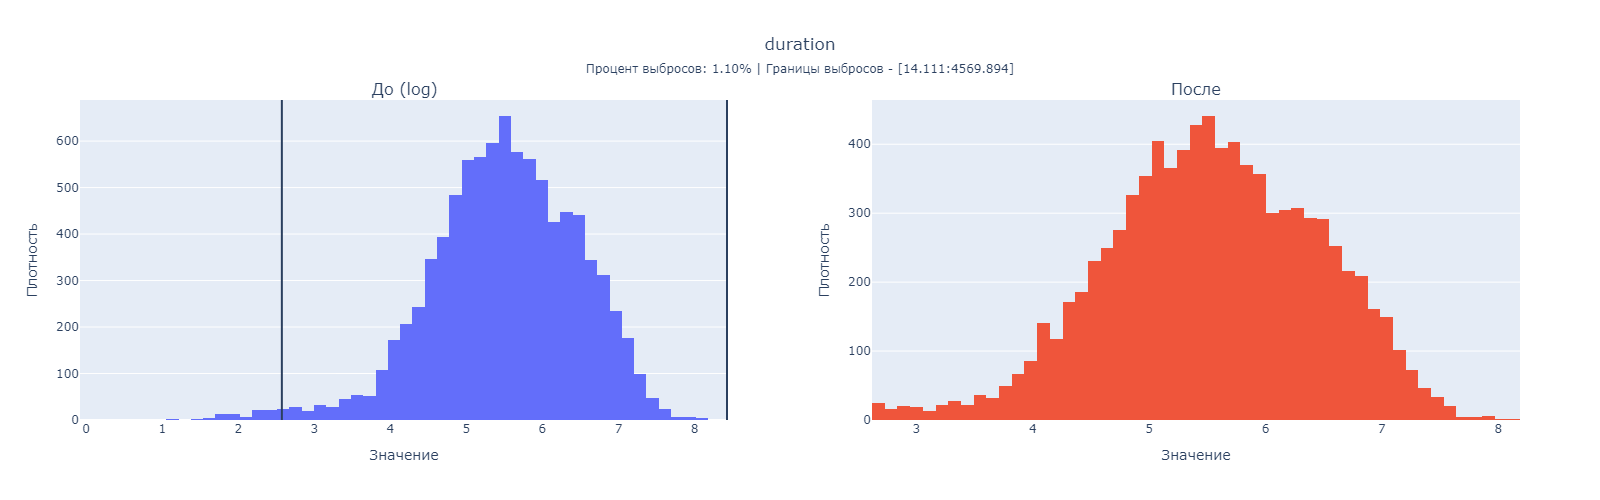

In [16]:
cols_to_clean = {
    'age': dict(method='define', left=18, right=90),
    'balance': dict(method='define', left=df['balance'].min(), right=40000),
    'duration': dict(method='z', log=True),
}

for col in cols_to_clean:
    idx_to_drop = clean_outliers(X_train[col], **cols_to_clean[col], kde_plt=False)[0].index
    X_train.drop(index=idx_to_drop, inplace=True)
    y_train.drop(index=idx_to_drop, inplace=True)

### Отбор признаков

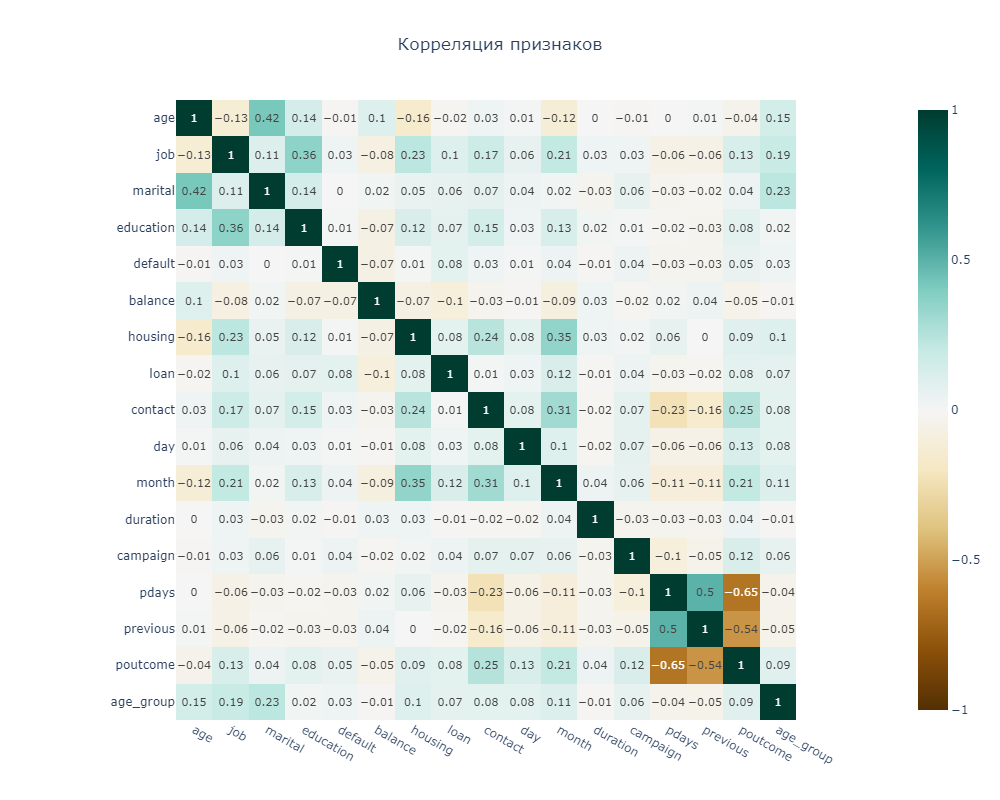

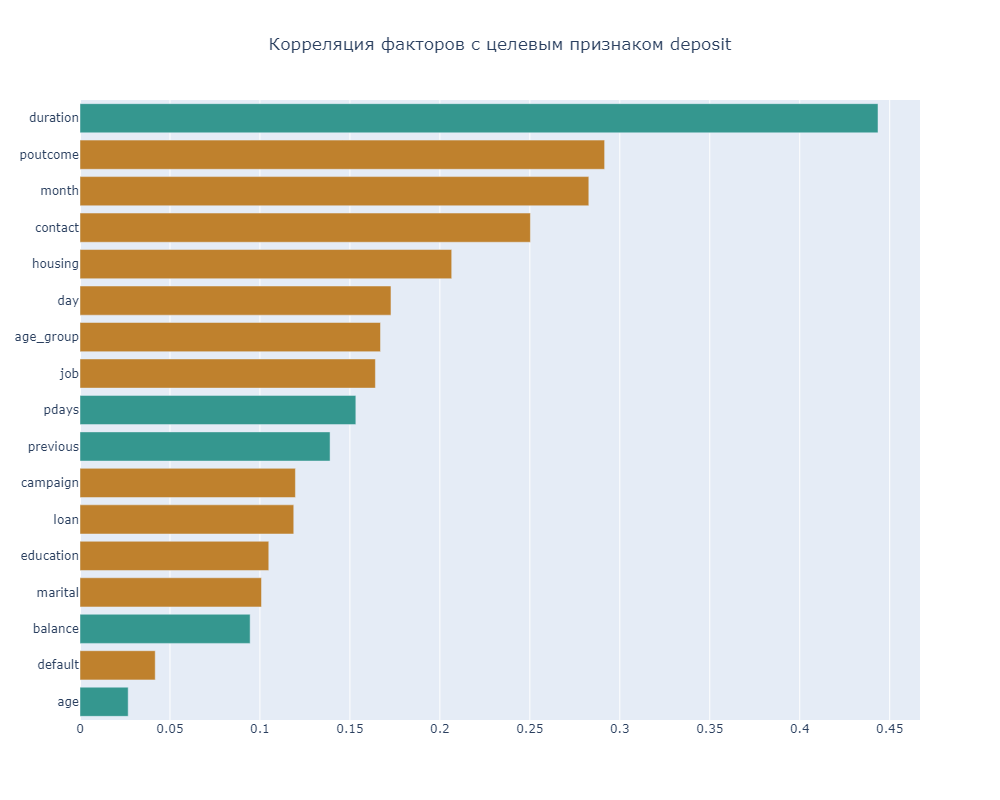

In [17]:
mc = MulticollinearityCleaner(verbose=2)
mc.fit(X_train, y_train)
X_train = mc.transform(X_train)
X_test = mc.transform(X_test)
for col in mc.cols_to_drop:
    if col in cat_cols:
        cat_cols.remove(col)
    if col in num_cols:
        num_cols.remove(col)

In [18]:
print(f'{np.linalg.matrix_rank(mc.corr)}/{X_train.shape[1]+1} линейно независимых признаков')
print('Нет сильно коррелирующих признаков' if mc.high_corr.empty else mc.high_corr)
display(mc.y_corr)

18/18 линейно независимых признаков
Нет сильно коррелирующих признаков


duration     0.443496
poutcome    -0.291562
month       -0.282783
contact     -0.250321
housing     -0.206576
day         -0.172825
age_group   -0.167006
job         -0.164172
pdays        0.153298
previous     0.138977
campaign    -0.119722
loan        -0.118802
education   -0.104918
marital     -0.100878
balance      0.094558
default     -0.041808
age          0.026774
Name: deposit, dtype: float64

In [19]:
# Удаление неинформативных признаков
lic = LowInformationCleaner(verbose=1)
lic.fit(X_train)
X_train = lic.transform(X_train)
X_test = lic.transform(X_test)
for col in lic.cols_to_drop:
    if col in cat_cols:
        cat_cols.remove(col)
    if col in num_cols:
        num_cols.remove(col)

### Нормализация и стандартизация

In [20]:
mms = MinMaxScaler()
stds = StandardScaler()

mms.fit(X_train[cat_cols])
X_train[cat_cols] = mms.transform(X_train[cat_cols])
X_test[cat_cols] = mms.transform(X_test[cat_cols])
stds.fit(X_train[num_cols])
X_train[num_cols] = stds.transform(X_train[num_cols])
X_test[num_cols] = stds.transform(X_test[num_cols])

## Обучение

In [21]:
cv = StratifiedKFold(5)
model_logs = defaultdict(dict)

def log_metrics(model, name, X, y):
    start_time = time.time()
    model.fit(X, y)
    train_duration = time.time() - start_time 
    mtrcs = [metrics.accuracy_score, metrics.precision_score, metrics.recall_score, metrics.f1_score]
    threshold, _ = get_pr_curve(model, X_train, y_train, cv=cv)
    y_pred_train = pd.Series(model.predict_proba(X_train)[:, 1]).apply(lambda x: 1 if x > threshold else 0)
    y_pred_test = pd.Series(model.predict_proba(X_test)[:, 1]).apply(lambda x: 1 if x > threshold else 0)
    scores = {}
    for metric in mtrcs:
        scores[metric.__name__] = metric(y_train, y_pred_train), cross_val_score(model, X_train, y_train, cv=cv,
                                                                                 n_jobs=-1, scoring=metrics.make_scorer(metric)).mean(), metric(y_test, y_pred_test)
    model_logs[name] = {'train_duration': train_duration, 'scores': scores}

In [22]:
# Logistic Regression
lr = LogisticRegression(random_state=RANDOM_STATE, solver='sag', max_iter=1000, n_jobs=-1)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=6, random_state=RANDOM_STATE, criterion='entropy')

# Random Forest
rf = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)

# Gradient Boosting
gb = ensemble.GradientBoostingClassifier(random_state=RANDOM_STATE)

# Stacking
sc = ensemble.StackingClassifier(estimators=[('Decision Tree', DecisionTreeClassifier(max_depth=7, min_samples_split=5, random_state=RANDOM_STATE)),
                                             ('Logistic Regression', LogisticRegression(solver='sag', max_iter=1000, random_state=RANDOM_STATE)),
                                             ('Gradient Boosting', ensemble.GradientBoostingClassifier(random_state=RANDOM_STATE))],
                                 final_estimator=LogisticRegression(random_state=RANDOM_STATE), n_jobs=-1)

# Gradient Boosting + Optuna
def objective(trial: optuna.Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 4, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 2, 1)
    }
    model = ensemble.GradientBoostingClassifier(**params, random_state=RANDOM_STATE)
    score = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='f1', n_jobs=-1).mean()
    return score


print('Gradient Boosting Optuna:')
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE), direction='maximize')
study.optimize(objective, n_trials=10)
gbo = ensemble.GradientBoostingClassifier(**study.best_params, random_state=RANDOM_STATE)

# Random Forest + Optuna
def objective(trial: optuna.Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
        'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1)
    }
    model = ensemble.RandomForestClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), scoring='f1', n_jobs=-1).mean()
    return score


print('Random Forest Optuna:')
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE), direction='maximize')
study.optimize(objective, n_trials=20)

rfo = ensemble.RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE, n_jobs=-1)



[I 2025-12-11 15:09:14,681] A new study created in memory with name: no-name-9f44734a-35fa-4413-a6e7-6cbbabb12a92


Gradient Boosting Optuna:


[I 2025-12-11 15:09:26,439] Trial 0 finished with value: 0.840173852219994 and parameters: {'n_estimators': 175, 'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.840173852219994.
[I 2025-12-11 15:09:34,729] Trial 1 finished with value: 0.8392917319798678 and parameters: {'n_estimators': 220, 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.840173852219994.
[I 2025-12-11 15:09:39,125] Trial 2 finished with value: 0.8397174691595948 and parameters: {'n_estimators': 111, 'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.840173852219994.
[I 2025-12-11 15:09:46,078] Trial 3 finished with value: 0.8398134522092974 and parameters: {'n_estimators': 242, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.840173852219994.
[I 2025-12-11 15:09:52,679] Trial 4 finished with value: 0.8406273917259286 and parameters: {'n_estimators': 267, 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.8406273917259

Random Forest Optuna:


[I 2025-12-11 15:10:18,694] Trial 0 finished with value: 0.8438113269323766 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8438113269323766.
[I 2025-12-11 15:10:22,217] Trial 1 finished with value: 0.843461005568798 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8438113269323766.
[I 2025-12-11 15:10:24,453] Trial 2 finished with value: 0.8436713118521639 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8438113269323766.
[I 2025-12-11 15:10:27,385] Trial 3 finished with value: 0.8398185187551623 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8438113269323766.
[I 2025-12-11 15:10:30,186] Trial 4 finished with value: 0.8450078778080409 and parameters: {'n_estimators': 184, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.845

In [23]:
models = {
    'Logistic Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Stacking': sc,
    'Gradient Boosting + Optuna': gbo,
    'Random Forest + Optuna': rfo
}
for name, model in models.items():
    log_metrics(model, name, X_train, y_train)

## Результаты

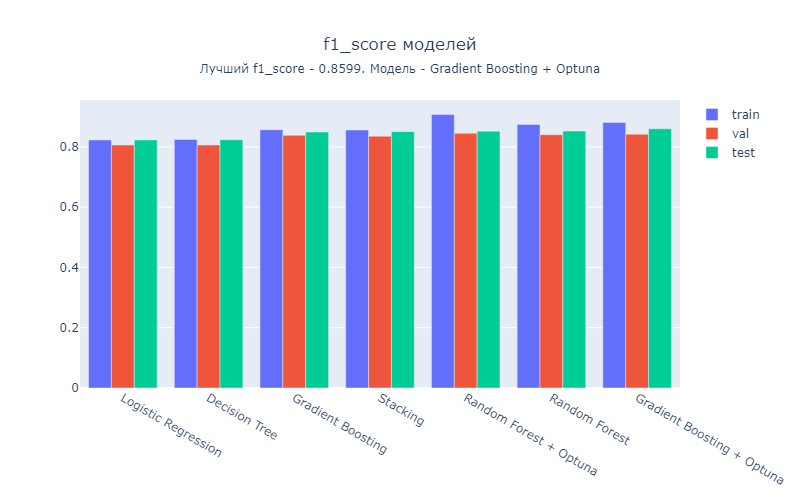

In [24]:
def vis_scores(scores):
    scores_f1 = pd.DataFrame(columns=['train', 'val', 'test'])
    for name in scores:
        scores_f1.loc[name, :] = scores[name]['scores']['f1_score'][0], scores[name]['scores']['f1_score'][1], scores[name]['scores']['f1_score'][2]
    scores_f1.sort_values(by='test', ascending=True, inplace=True)
    scores_f1 = scores_f1.astype('float')

    fig = go.Figure()
    fig.add_trace(go.Bar(y=scores_f1['train'], x=scores_f1.index, orientation='v', name='train'))
    fig.add_trace(go.Bar(y=scores_f1['val'], x=scores_f1.index, orientation='v', name='val'))
    fig.add_trace(go.Bar(y=scores_f1['test'], x=scores_f1.index, orientation='v', name='test'))

    fig.update_layout(barmode='group', width=800, title='f1_score моделей',
                      title_subtitle_text=f'Лучший f1_score - {scores_f1["test"].max():.4f}. Модель - {scores_f1["test"].idxmax()}', title_x=0.5)
    fig.show()


vis_scores(model_logs)

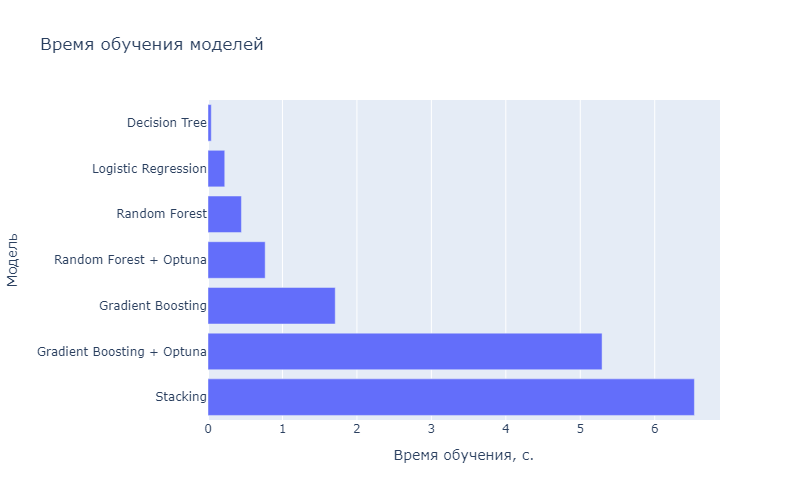

In [25]:
px.bar(pd.DataFrame(model_logs).T['train_duration'].astype('float').sort_values(ascending=False).round(3), 
       width=800, orientation='h', 
       title='Время обучения моделей', labels={'index':'Модель', 'value': 'Время обучения, с.'}).update_layout(showlegend=False).show()

In [27]:
print(pd.DataFrame({model_name: model_logs[model_name]['scores']['f1_score']
                    for model_name in model_logs}, index=['train', 'valid', 'test']).T
      .sort_values(by='test', ascending=False).round(3).to_markdown(tablefmt='github'))

|                            |   train |   valid |   test |
|----------------------------|---------|---------|--------|
| Gradient Boosting + Optuna |   0.881 |   0.842 |  0.86  |
| Random Forest              |   0.874 |   0.841 |  0.852 |
| Random Forest + Optuna     |   0.908 |   0.845 |  0.852 |
| Stacking                   |   0.856 |   0.835 |  0.851 |
| Gradient Boosting          |   0.857 |   0.838 |  0.849 |
| Decision Tree              |   0.825 |   0.806 |  0.824 |
| Logistic Regression        |   0.823 |   0.806 |  0.823 |
